# Comparing Eulerian surface velocity fields from ocean-only (uncoupled) and ocean-wave (coupled) model simulations for the Mediterranean Sea

In [1]:
import os.path
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm

import xarray as xr
import numpy as np
from xhistogram.xarray import histogram

In [2]:
############################

plot_only = False
# If you run notebook for the first time, set plot_only to False,
# this will make sure that you calculate all the averaged fields and save them for later use 
# (as defined in section 1 below)
# Afterwards set plot_only to avoid re-computation of the avreages every time
# (all cells in section 1 will not be executed)

############################

datapath = '/Users/siren/Data/IMMERSE/'
# path, were unprocessed data is stored

#outpath_data = '/Users/siren/IMMERSE_waves/develop-mac/data/Eulerian-revisedNEMO/'
#outpath_figs = '/Users/siren/IMMERSE_waves/develop-mac/figures/revisedNEMO/'

outpath_data = '/Users/siren/IMMERSE_waves/develop-mac/data/Eulerian-revisedNEMO-nounigrid/'
outpath_figs = '/Users/siren/IMMERSE_waves/develop-mac/figures/revisedNEMO/'

## 1. Loading, process, and save post-processed Eulerian data

### 1.1 Loading unprocessed Eulerian data on original grid

In [3]:
if plot_only == False:
    datapath_nc = datapath + 'surface_TKE_UNC/'
    datapath_c = datapath + 'surface_TKE_CO/'
    uvars_ugrid_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_U.nc')),
                                 chunks=None, combine='by_coords')
    vvars_vgrid_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_V.nc')),
                                 chunks=None, combine='by_coords')
    uvars_ugrid_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_U.nc')),
                                chunks=None, combine='by_coords')
    vvars_vgrid_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_V.nc')),
                                chunks=None, combine='by_coords')

In [4]:
gridpath = (datapath + 'domain/mesh_mask.nc')
grid = xr.open_dataset(gridpath, drop_variables=('x','y'))

In [5]:
regionmaskpath = (datapath + 'domain/MEDregions.nc')
regionmask = xr.open_dataset(regionmaskpath).rename({'jm':'y','im':'x'})

### 1.2 Not interpolating data on same grid, but selecting surface level

In [6]:
if plot_only == False:
    vvars_c = vvars_vgrid_c.isel(depthv=0)
    vvars_nc = vvars_vgrid_nc.isel(depthv=0)
    uvars_c = uvars_ugrid_c.isel(depthu=0)
    uvars_nc = uvars_ugrid_nc.isel(depthu=0)

### 1.2 Calculate speed and direction

Direction is calculated following partially the recipe on this website:
https://support.nortekgroup.com/hc/en-us/articles/360012774640-How-to-calculate-current-speed-and-direction-from-three-beam-ADCP-velocity-components
(angle = atan2(Vnorth,Veast), direction = 180 + 180/pi*(atan2(-Vnorth,-Veast)) )

In [7]:
def calc_velspeed(u,v):
    speed = (u**2 + v**2)**(1/2)
    return speed

In [8]:
def calc_veldir(u,v):
    dir = 180 + 180/np.pi*(np.arctan2(-v,-u)) 
    # -u,-v needed to get direction in which current is pointing, instead from which it is coming
    # (arctan calculates direction from given point to origin, and not from origin to point)
    # also note that arctan2 is defined in python with (y,x) instead of (x,y)
    return dir

In [9]:
if plot_only == False:
    
    u_Enc = uvars_nc.vozocrtx
    v_Enc = vvars_nc.vomecrty
    speed_Enc = calc_velspeed(u_Enc,v_Enc)
    direction_Enc = xr.apply_ufunc(calc_veldir, u_Enc, v_Enc, dask="allowed")

    u_Ec = uvars_c.vozocrtx
    v_Ec = vvars_c.vomecrty
    speed_Ec = calc_velspeed(u_Ec,v_Ec)
    direction_Ec = xr.apply_ufunc(calc_veldir, u_Ec, v_Ec, dask="allowed")
    
    u_Sc = uvars_c.usd
    v_Sc = vvars_c.vsd
    speed_Sc = calc_velspeed(u_Sc,v_Sc)
    direction_Sc = xr.apply_ufunc(calc_veldir, u_Sc, v_Sc, dask="allowed")

    u_EcSc = u_Ec + u_Sc
    v_EcSc = v_Ec + v_Sc
    speed_EcSc = calc_velspeed(u_EcSc,v_EcSc)
    direction_EcSc = xr.apply_ufunc(calc_veldir, u_EcSc, v_EcSc, dask="allowed")

    u_EncSc = u_Enc + u_Sc
    v_EncSc = v_Enc + v_Sc
    speed_EncSc = calc_velspeed(u_EncSc,v_EncSc)
    direction_EncSc = xr.apply_ufunc(calc_veldir, u_EncSc, v_EncSc, dask="allowed")

In [10]:
# save speed and direction

#if plot_only == False:
#    
#    nav_lon = u_Ec.nav_lon.values
#    nav_lat = u_Ec.nav_lat.values
#    
#    speed_ds = xr.Dataset(data_vars = {'Enc': speed_Enc.where(speed_Enc !=0),
#                                       'Ec': speed_Ec.where(speed_Ec !=0),
#                                       'Sc': speed_Sc.where(speed_Sc !=0),
#                                       'EcSc': speed_EcSc.where(speed_EcSc !=0),
#                                       'EncSc': speed_EncSc.where(speed_EncSc !=0)},
#                                       coords = {'nav_lon': (('y','x'),nav_lon),
#                                                 'nav_lat': (('y','x'),nav_lat)})
#
#    direction_ds = xr.Dataset(data_vars = {'Enc': direction_Enc.where(direction_Enc !=0),
#                                           'Ec': direction_Ec.where(direction_Ec !=0),
#                                           'Sc': direction_Sc.where(direction_Sc !=0),
#                                           'EcSc': direction_EcSc.where(direction_EcSc !=0),
#                                           'EncSc': direction_EncSc.where(direction_EncSc !=0)},
#                                           coords = {'nav_lon': (('y','x'),nav_lon),
#                                                     'nav_lat': (('y','x'),nav_lat)})
#
#    speed_ds.to_netcdf(outpath_data + 'Speed-tave.nc')
#    direction_ds.to_netcdf(outpath_data + 'Direction-tave.nc')

### 1.3 Calculate temporal averages of speed and velocity magnitude and direction

Note that mean speed and mean velocity magnitude are not the same (mean velocity magnitude <= mean speed): https://www.vedantu.com/physics/average-speed-and-average-velocity

In [11]:
# annual averages

if plot_only == False:
    
    u_Enc_tave = u_Enc.mean(dim='time_counter').compute()
    u_Ec_tave = u_Ec.mean(dim='time_counter').compute()
    u_Sc_tave = u_Sc.mean(dim='time_counter').compute()
    u_EcSc_tave = u_EcSc.mean(dim='time_counter').compute()
    u_EncSc_tave = u_EncSc.mean(dim='time_counter').compute()

    v_Enc_tave = v_Enc.mean(dim='time_counter').compute()
    v_Ec_tave = v_Ec.mean(dim='time_counter').compute()
    v_Sc_tave = v_Sc.mean(dim='time_counter').compute()
    v_EcSc_tave = v_EcSc.mean(dim='time_counter').compute()
    v_EncSc_tave = v_EncSc.mean(dim='time_counter').compute()

    speed_Enc_tave = speed_Enc.mean(dim='time_counter').compute()
    speed_Ec_tave = speed_Ec.mean(dim='time_counter').compute()
    speed_Sc_tave = speed_Sc.mean(dim='time_counter').compute()
    speed_EcSc_tave = speed_EcSc.mean(dim='time_counter').compute()
    speed_EncSc_tave = speed_EncSc.mean(dim='time_counter').compute()

    direction_Enc_tave = xr.apply_ufunc(calc_veldir, u_Enc_tave, v_Enc_tave, dask="allowed")
    direction_Ec_tave = xr.apply_ufunc(calc_veldir, u_Ec_tave, v_Ec_tave, dask="allowed")
    direction_Sc_tave = xr.apply_ufunc(calc_veldir, u_Sc_tave, v_Sc_tave, dask="allowed")
    direction_EcSc_tave = xr.apply_ufunc(calc_veldir, u_EcSc_tave, v_EcSc_tave, dask="allowed")
    direction_EncSc_tave = xr.apply_ufunc(calc_veldir, u_EncSc_tave, v_EncSc_tave, dask="allowed")

    magnitude_Enc_tave = calc_velspeed(u_Enc_tave,v_Enc_tave)
    magnitude_Ec_tave = calc_velspeed(u_Ec_tave,v_Ec_tave)
    magnitude_Sc_tave = calc_velspeed(u_Sc_tave,v_Sc_tave)
    magnitude_EcSc_tave = calc_velspeed(u_EcSc_tave,v_EcSc_tave)
    magnitude_EncSc_tave = calc_velspeed(u_EncSc_tave,v_EncSc_tave)


In [12]:
## seasonal averages

if plot_only == False:
    
    u_Enc_tsave = u_Enc.groupby('time_counter.season').mean(dim='time_counter').compute()
    u_Ec_tsave = u_Ec.groupby('time_counter.season').mean(dim='time_counter').compute()
    u_Sc_tsave = u_Sc.groupby('time_counter.season').mean(dim='time_counter').compute()
    u_EcSc_tsave = u_EcSc.groupby('time_counter.season').mean(dim='time_counter').compute()
    u_EncSc_tsave = u_EncSc.groupby('time_counter.season').mean(dim='time_counter').compute()

    v_Enc_tsave = v_Enc.groupby('time_counter.season').mean(dim='time_counter').compute()
    v_Ec_tsave = v_Ec.groupby('time_counter.season').mean(dim='time_counter').compute()
    v_Sc_tsave = v_Sc.groupby('time_counter.season').mean(dim='time_counter').compute()
    v_EcSc_tsave = v_EcSc.groupby('time_counter.season').mean(dim='time_counter').compute()
    v_EncSc_tsave = v_EncSc.groupby('time_counter.season').mean(dim='time_counter').compute()

    speed_Enc_tsave = speed_Enc.groupby('time_counter.season').mean(dim='time_counter').compute()
    speed_Ec_tsave = speed_Ec.groupby('time_counter.season').mean(dim='time_counter').compute()
    speed_Sc_tsave = speed_Sc.groupby('time_counter.season').mean(dim='time_counter').compute()
    speed_EcSc_tsave = speed_EcSc.groupby('time_counter.season').mean(dim='time_counter').compute()
    speed_EncSc_tsave = speed_EncSc.groupby('time_counter.season').mean(dim='time_counter').compute()

    direction_Enc_tsave = xr.apply_ufunc(calc_veldir, u_Enc_tsave, v_Enc_tsave, dask="allowed")
    direction_Ec_tsave = xr.apply_ufunc(calc_veldir, u_Ec_tsave, v_Ec_tsave, dask="allowed")
    direction_Sc_tsave = xr.apply_ufunc(calc_veldir, u_Sc_tsave, v_Sc_tsave, dask="allowed")
    direction_EcSc_tsave = xr.apply_ufunc(calc_veldir, u_EcSc_tsave, v_EcSc_tsave, dask="allowed")
    direction_EncSc_tsave = xr.apply_ufunc(calc_veldir, u_EncSc_tsave, v_EncSc_tsave, dask="allowed")

    magnitude_Enc_tsave = calc_velspeed(u_Enc_tsave,v_Enc_tsave)
    magnitude_Ec_tsave = calc_velspeed(u_Ec_tsave,v_Ec_tsave)
    magnitude_Sc_tsave = calc_velspeed(u_Sc_tsave,v_Sc_tsave)
    magnitude_EcSc_tsave = calc_velspeed(u_EcSc_tsave,v_EcSc_tsave)
    magnitude_EncSc_tsave = calc_velspeed(u_EncSc_tsave,v_EncSc_tsave)
    


### 1.4 Save temporally averaged fields

In [13]:

# annual averages

if plot_only == False:
    
    nav_lon = u_Enc_tave.nav_lon.values
    nav_lat = u_Enc_tave.nav_lat.values
    nav_lon_v = v_Enc_tave.nav_lon.values
    nav_lat_v = v_Enc_tave.nav_lat.values

    u_tave_ds = xr.Dataset(data_vars = {'Enc': u_Enc_tave.where(u_Enc_tave !=0),
                                        'Ec': u_Ec_tave.where(u_Ec_tave !=0),
                                        'Sc': u_Sc_tave.where(u_Sc_tave !=0),
                                        'EcSc': u_EcSc_tave.where(u_EcSc_tave !=0),
                                        'EncSc': u_EncSc_tave.where(u_EncSc_tave !=0)},
                               coords = {'nav_lon': (('y','x'),nav_lon),
                                         'nav_lat': (('y','x'),nav_lat)})

    v_tave_ds = xr.Dataset(data_vars = {'Enc': v_Enc_tave.where(v_Enc_tave !=0),
                                        'Ec': v_Ec_tave.where(v_Ec_tave !=0),
                                        'Sc': v_Sc_tave.where(v_Sc_tave !=0),
                                        'EcSc': v_EcSc_tave.where(v_EcSc_tave !=0),
                                        'EncSc': v_EncSc_tave.where(v_EncSc_tave !=0)},
                               coords = {'nav_lon': (('y','x'),nav_lon_v),
                                         'nav_lat': (('y','x'),nav_lat_v)})
    
    speed_tave_ds = xr.Dataset(data_vars = {'Enc': speed_Enc_tave.where(speed_Enc_tave !=0),
                                            'Ec': speed_Ec_tave.where(speed_Ec_tave !=0),
                                            'Sc': speed_Sc_tave.where(speed_Sc_tave !=0),
                                            'EcSc': speed_EcSc_tave.where(speed_EcSc_tave !=0),
                                            'EncSc': speed_EncSc_tave.where(speed_EncSc_tave !=0)},
                               coords = {'nav_lon': (('y','x'),nav_lon),
                                         'nav_lat': (('y','x'),nav_lat)})

    direction_tave_ds = xr.Dataset(data_vars = {'Enc': direction_Enc_tave.where(direction_Enc_tave !=0),
                                                'Ec': direction_Ec_tave.where(direction_Ec_tave !=0),
                                                'Sc': direction_Sc_tave.where(direction_Sc_tave !=0),
                                                'EcSc': direction_EcSc_tave.where(direction_EcSc_tave !=0),
                                                'EncSc': direction_EncSc_tave.where(direction_EncSc_tave !=0)},
                                   coords = {'nav_lon': (('y','x'),nav_lon),
                                             'nav_lat': (('y','x'),nav_lat)})
    
    magnitude_tave_ds = xr.Dataset(data_vars = {'Enc': magnitude_Enc_tave.where(magnitude_Enc_tave !=0),
                                                'Ec': magnitude_Ec_tave.where(magnitude_Ec_tave !=0),
                                                'Sc': magnitude_Sc_tave.where(magnitude_Sc_tave !=0),
                                                'EcSc': magnitude_EcSc_tave.where(magnitude_EcSc_tave !=0),
                                                'EncSc': magnitude_EncSc_tave.where(magnitude_EncSc_tave !=0)},
                                   coords = {'nav_lon': (('y','x'),nav_lon),
                                             'nav_lat': (('y','x'),nav_lat)})
    
    u_tave_ds.to_netcdf(outpath_data + 'U-tave.nc')
    v_tave_ds.to_netcdf(outpath_data + 'V-tave.nc')
    speed_tave_ds.to_netcdf(outpath_data + 'Speed-tave.nc')
    direction_tave_ds.to_netcdf(outpath_data + 'Direction-tave.nc')
    magnitude_tave_ds.to_netcdf(outpath_data + 'Magnitude-tave.nc')

In [14]:
# seasonal averages

if plot_only == False:
    
    nav_lon = u_EcSc.nav_lon.values
    nav_lat = u_EcSc.nav_lat.values
    nav_lon_v = v_EcSc.nav_lon.values
    nav_lat_v = v_EcSc.nav_lat.values
    
    u_tsave_ds = xr.Dataset(data_vars = {'Enc': u_Enc_tsave.where(u_Enc_tsave !=0),
                                         'Ec': u_Ec_tsave.where(u_Ec_tsave !=0),
                                         'Sc': u_Sc_tsave.where(u_Sc_tsave !=0),
                                         'EcSc': u_EcSc_tsave.where(u_EcSc_tsave !=0),
                                         'EncSc': u_EncSc_tsave.where(u_EncSc_tsave !=0)},
                            coords = {'nav_lon': (('y','x'),nav_lon),
                                      'nav_lat': (('y','x'),nav_lat)})

    v_tsave_ds = xr.Dataset(data_vars = {'Enc': v_Enc_tsave.where(v_Enc_tsave !=0),
                                         'Ec': direction_Ec_tsave.where(v_Ec_tsave !=0),
                                         'Sc': direction_Sc_tsave.where(v_Sc_tsave !=0),
                                         'EcSc': v_EcSc_tsave.where(v_EcSc_tsave !=0),
                                         'EncSc': v_EncSc_tsave.where(v_EncSc_tsave !=0)},
                            coords = {'nav_lon_v': (('y','x'),nav_lon),
                                      'nav_lat_v': (('y','x'),nav_lat)})   
    speed_tsave_ds = xr.Dataset(data_vars = {'Enc': speed_Enc_tsave.where(speed_Enc_tsave !=0),
                                             'Ec': speed_Ec_tsave.where(speed_Ec_tsave !=0),
                                             'Sc': speed_Sc_tsave.where(speed_Sc_tsave !=0),
                                             'EcSc': speed_EcSc_tsave.where(speed_EcSc_tsave !=0),
                                             'EncSc': speed_EncSc_tsave.where(speed_EncSc_tsave !=0)},
                                coords = {'nav_lon': (('y','x'),nav_lon),
                                          'nav_lat': (('y','x'),nav_lat)})

    direction_tsave_ds = xr.Dataset(data_vars = {'Enc': direction_Enc_tsave.where(direction_Enc_tsave !=0),
                                                 'Ec': direction_Ec_tsave.where(direction_Ec_tsave !=0),
                                                 'Sc': direction_Sc_tsave.where(direction_Sc_tsave !=0),
                                                 'EcSc': direction_EcSc_tsave.where(direction_EcSc_tsave !=0),
                                                 'EncSc': direction_EncSc_tsave.where(direction_EncSc_tsave !=0)},
                                    coords = {'nav_lon': (('y','x'),nav_lon),
                                              'nav_lat': (('y','x'),nav_lat)})
    
    magnitude_tsave_ds = xr.Dataset(data_vars = {'Enc': magnitude_Enc_tsave.where(magnitude_Enc_tsave !=0),
                                                'Ec': magnitude_Ec_tsave.where(magnitude_Ec_tsave !=0),
                                                'Sc': magnitude_Sc_tsave.where(magnitude_Sc_tsave !=0),
                                                'EcSc': magnitude_EcSc_tsave.where(magnitude_EcSc_tsave !=0),
                                                'EncSc': magnitude_EncSc_tsave.where(magnitude_EncSc_tsave !=0)},
                                    coords = {'nav_lon': (('y','x'),nav_lon),
                                              'nav_lat': (('y','x'),nav_lat)})  
      
    u_tsave_ds.to_netcdf(outpath_data + 'U-tseasonave.nc')
    v_tsave_ds.to_netcdf(outpath_data + 'V-tseasonave.nc')
    speed_tsave_ds.to_netcdf(outpath_data + 'Speed-tseasonave.nc')
    direction_tsave_ds.to_netcdf(outpath_data + 'Direction-tseasonave.nc')
    magnitude_tsave_ds.to_netcdf(outpath_data + 'Magnitude-tseasonave.nc')

## 2. Plot (and statistically evaluate) post-processed data

### 2.1 Load temporal averaged fields

In [ ]:
u_tave_ds = xr.open_dataset(outpath_data + 'U-tave.nc')
v_tave_ds = xr.open_dataset(outpath_data + 'V-tave.nc')
speed_tave_ds = xr.open_dataset(outpath_data + 'Speed-tave.nc')
direction_tave_ds = xr.open_dataset(outpath_data + 'Direction-tave.nc')
#u_tsave_ds = xr.open_dataset(outpath_data + 'U-tseasonave.nc')
#v_tsave_ds = xr.open_dataset(outpath_data + 'V-tseasonave.nc')
speed_tsave_ds = xr.open_dataset(outpath_data + 'Speed-tseasonave.nc')
direction_tsave_ds = xr.open_dataset(outpath_data + 'Direction-tseasonave.nc')

### 2.2 Assess impact of current-wave coupling on time-mean velocity

/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_89325/2531960219.py:20: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var1.nav_lon, var1.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_89325/2531960219.py:20: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var1.nav_lon, var1.nav_lat,


Text(0, 0.5, 'Stokes drift')

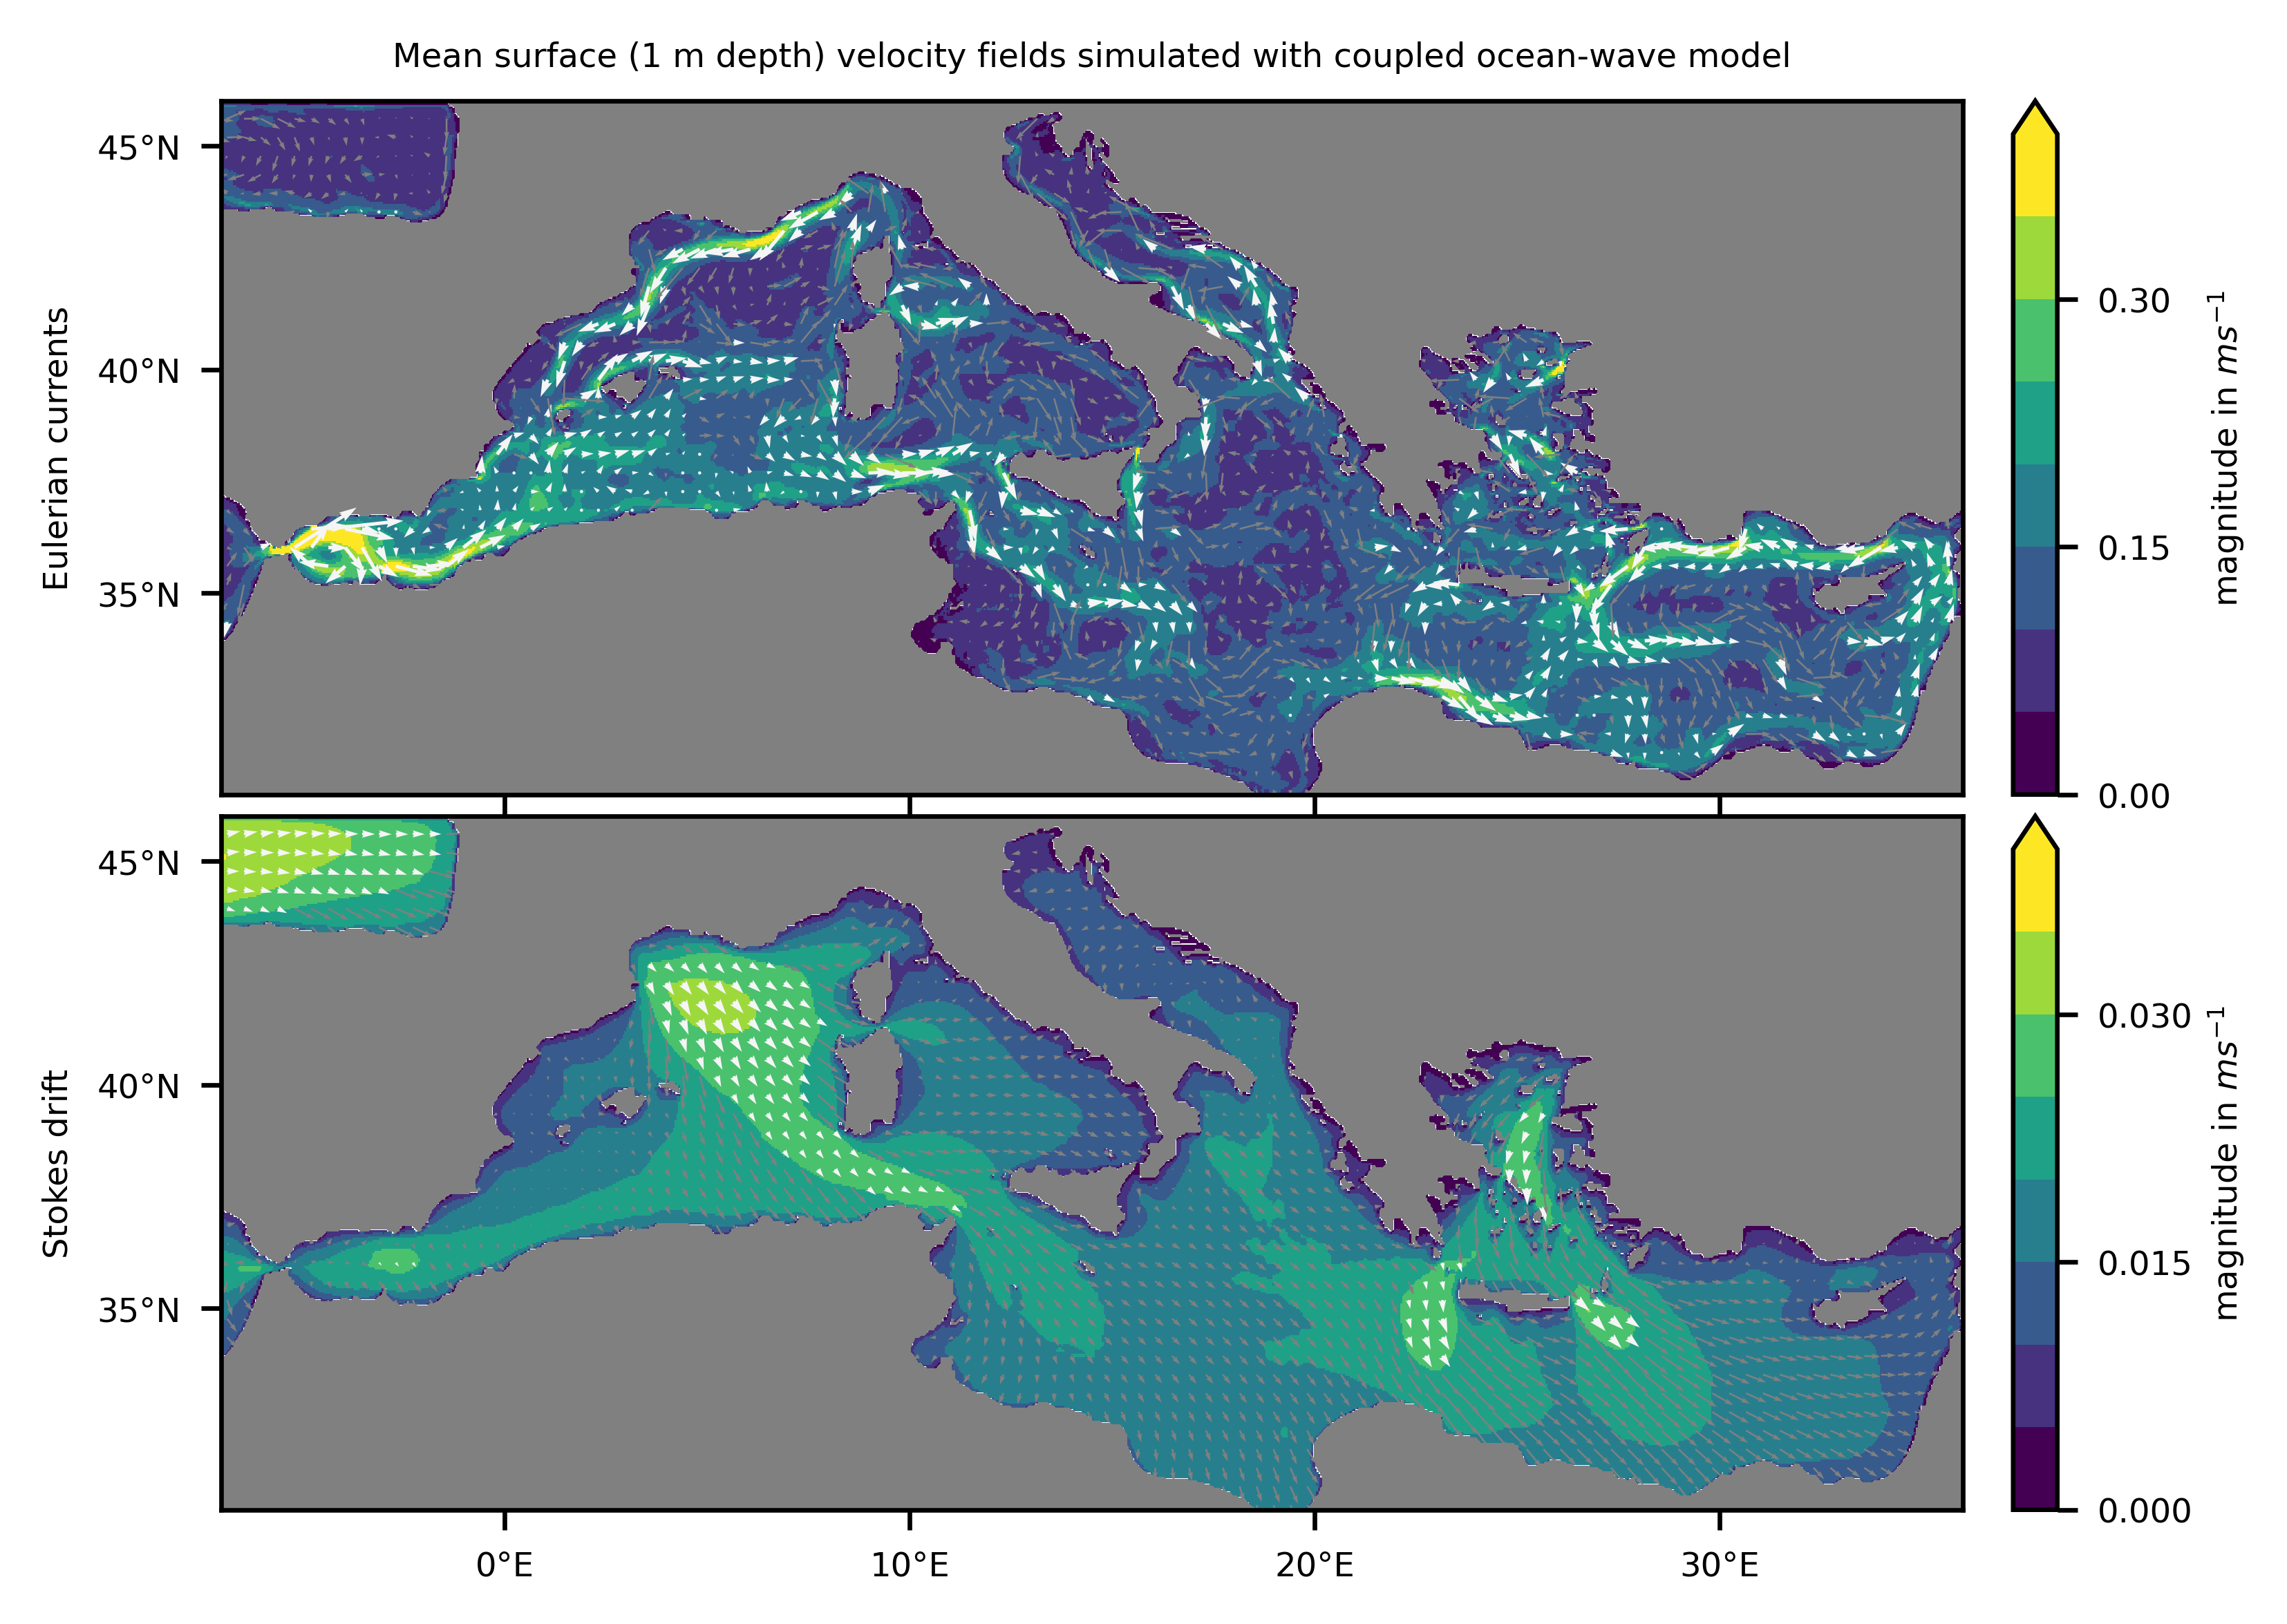

In [15]:
lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'
fs='xx-small'
nctic=3
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamu.isel(time_counter=0), grid.gphiu.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_velocity(var1):
    map = plt.pcolor(var1.nav_lon, var1.nav_lat,
                     var1,
                     cmap=colm, norm=norm,
                     shading='nearest')
    return map

def plot_veldir(var1,var2,var3,lowspeed=False):
    ind_v = slice(0,380,10)
    ind_u = slice(0,1300,10)
    plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.nav_lat.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var2.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           angles='xy', scale_units='xy',
           color = 'whitesmoke',
           width = 0.002)
    if lowspeed == True:
        plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.nav_lat.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var2.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   angles='xy', scale_units='xy',
                   color='grey',
                   width = 0.001)

def build_subplot_velocity(var1,speccolor,xticklabel=True,yticklabel=True):
    map = plot_velocity(var1)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,10,20,30])
    ax.set_yticks([35,40,45])
    xticklabs = ['0°E','10°E','20°E', '30°E']
    yticklabs = ['35°N','40°N','45°N']
    if xticklabel==False:
        ax.set_xticklabels([])
    else: 
        ax.set_xticklabels(xticklabs)
    if yticklabel==False:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels(yticklabs)
    ax.tick_params(axis='both', labelsize=fs)
    return map

fig = plt.figure(figsize=(6,4.5), dpi=600, constrained_layout=False)
gs2 = fig.add_gridspec(nrows=6, ncols=3, 
                       left=0.1, right=0.8,
                       wspace=0.03, hspace=0.1)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.1)


ax = fig.add_subplot(gs2[0:3,0:3])
colm = cm.viridis 
levs = np.arange(0, 0.45, 0.05)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
speedlim = 0.15 #0.15
var1 = u_tave_ds.Enc
var2 = v_tave_ds.Enc
var3 = speed_tave_ds.Enc
map = build_subplot_velocity(var3,col_nc, xticklabel=False, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
cbaxes = fig.add_subplot(gscbar[0:3,80:82])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.set_ylabel('Eulerian currents', fontsize=fs)
ax.text(42.5,latmin_plot+(latmax_plot-latmin_plot)/2,'magnitude in $m s^{-1}$', rotation=90, va='center', ha='center', fontsize=fs)
ax.set_title('Mean surface (1 m depth) velocity fields simulated with coupled ocean-wave model', fontsize=fs)

ax = fig.add_subplot(gs2[3:6,0:3])
colm = cm.viridis 
levs = np.arange(0, 0.045, 0.005)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
speedlim = 0.025 #0.025
var1 = u_tave_ds.Sc
var2 = v_tave_ds.Sc
var3 = speed_tave_ds.Sc
map = build_subplot_velocity(var3,col_nc, xticklabel=True, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
cbaxes = fig.add_subplot(gscbar[3:6,80:82])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.text(42.5,latmin_plot+(latmax_plot-latmin_plot)/2,'magnitude in $m s^{-1}$', rotation=90, va='center', ha='center', fontsize=fs)
ax.set_ylabel('Stokes drift', fontsize=fs)

In [16]:
def calc_reg_ave(var):
    var_rave = var.copy()*0
    var_rave_slim_list = []
    for i in range(17):
        reg = float(i + 1)
        regmask = regionmask.regs.assign_coords({'nav_lon':var.nav_lon, 'nav_lat':var.nav_lat})
        tmp = var.where(regionmask.regs == reg).mean(dim=['x','y'], skipna=True)
        tmp2 = (var.where(regionmask.regs == reg)*0 + tmp).fillna(0)
        var_rave = var_rave + tmp2
        var_rave_slim_list.append(tmp)
    var_rave_slim = xr.concat(var_rave_slim_list, dim='regs').assign_coords({'regs':np.arange(17)+1})
    return var_rave, var_rave_slim

In [17]:
speed_tave_rave_ds, speed_tave_rave_slim_ds = calc_reg_ave(speed_tave_ds)
direction_tave_rave_ds, direction_tave_rave_slim_ds = calc_reg_ave(direction_tave_ds)

In [18]:
speed_tsave_rave_ds, speed_tsave_rave_slim_ds = calc_reg_ave(speed_tsave_ds)
direction_tsave_rave_ds, direction_tsave_rave_slim_ds = calc_reg_ave(direction_tsave_ds)

/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_89325/3655831955.py:27: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var.nav_lon, var.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_89325/3655831955.py:27: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var.nav_lon, var.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_89325/3655831955.py:27: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

Text(0.5, 1.0, 'Impact of waves on surface velocities')

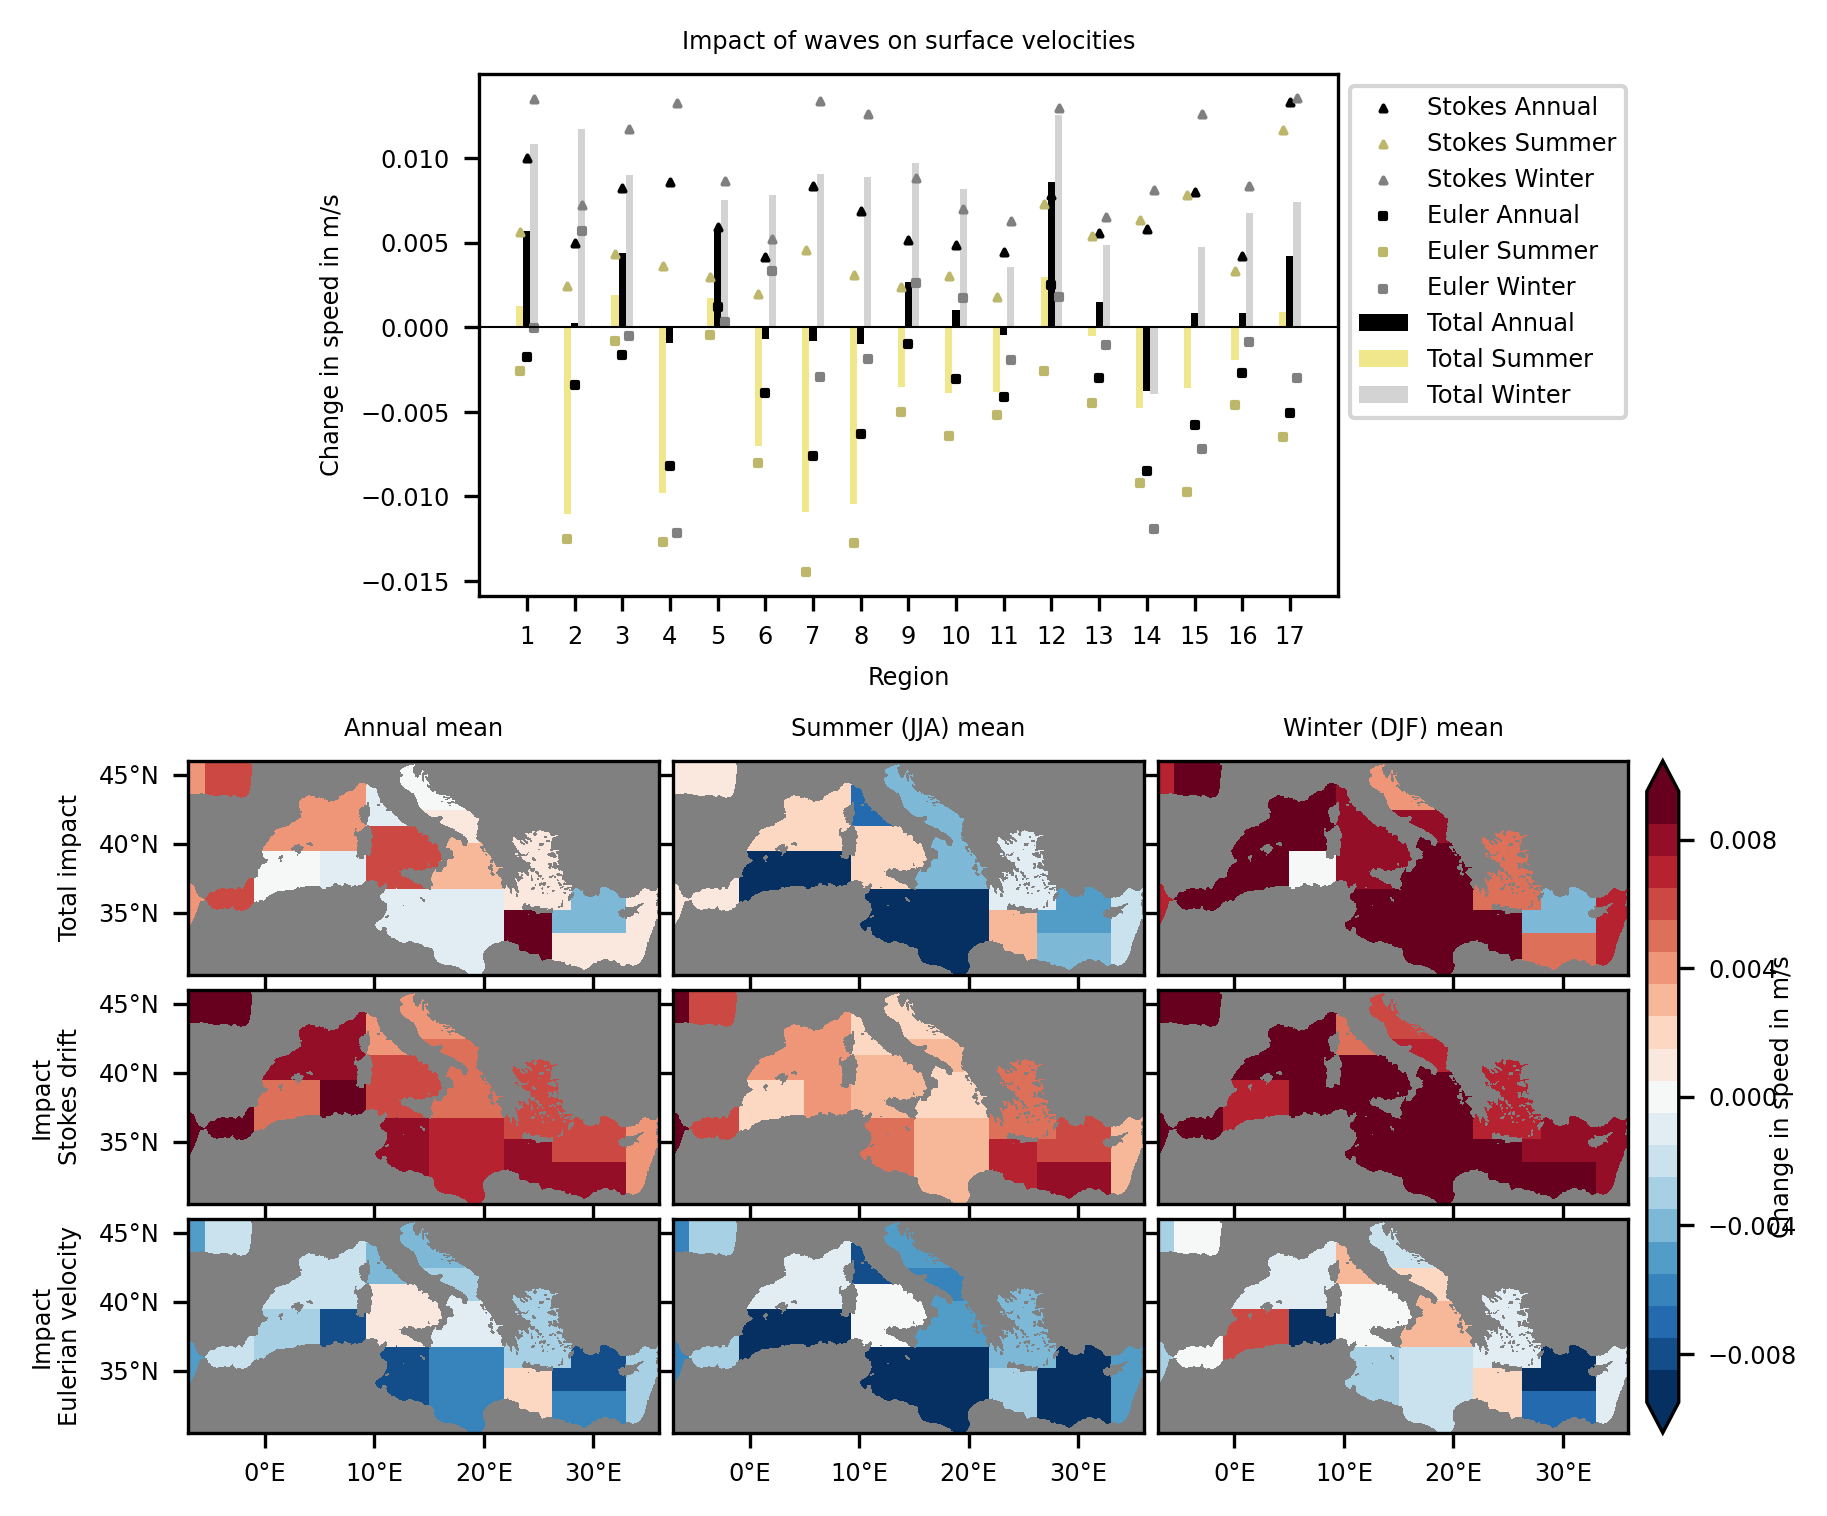

In [19]:
# Impact of waves on speed (regionally averaged) 

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=5

colm = cm.RdBu_r 
levs = np.arange(-0.01, 0.01, 0.001)
norm = colors.BoundaryNorm(boundaries=levs+0.001/2, ncolors=colm.N)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')
def build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,xticklabel=True,yticklabel=True):
    var_tmp = (var1 - var2)
    var, var_slim = calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map,var_slim

fig = plt.figure(figsize=(6,6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)


## Eulerian impact
### annual mean
ax = fig.add_subplot(gs[5,0])
var1 = speed_tave_ds.Ec
var2 = speed_tave_ds.Enc
map,Eul_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm)
cbaxes = fig.add_subplot(gscbar[3:6,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.set_ylabel('Impact\nEulerian velocity', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[5,1])
var1 = speed_tsave_ds.sel(season='JJA').Ec
var2 = speed_tsave_ds.sel(season='JJA').Enc
map,Eul_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
### winter mean
ax = fig.add_subplot(gs[5,2])
var1 = speed_tsave_ds.sel(season='DJF').Ec
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Eul_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)

## Stokes drift impact
### annual mean
ax = fig.add_subplot(gs[4,0])
var1 = speed_tave_ds.EncSc
var2 = speed_tave_ds.Enc
map, Sto_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Impact\nStokes drift', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[4,1])
var1 = speed_tsave_ds.sel(season='JJA').EncSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Sto_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
### winter mean
ax = fig.add_subplot(gs[4,2])
var1 = speed_tsave_ds.sel(season='DJF').EncSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Sto_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.text(50,latmin_plot+(latmax_plot-latmin_plot)/2, 'Change in speed in m/s', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)

## Total impact
### annual mean
ax = fig.add_subplot(gs[3,0])
var1 = speed_tave_ds.EcSc
var2 = speed_tave_ds.Enc
map, Tot_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Total impact', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[3,1])
var1 = speed_tsave_ds.sel(season='JJA').EcSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Tot_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)
### winter mean
ax = fig.add_subplot(gs[3,2])
var1 = speed_tsave_ds.sel(season='DJF').EcSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Tot_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)

ax = fig.add_subplot(gs2[0:2,1:4])
col_jja = 'khaki'
col_jja2 = 'darkkhaki'
col_djf = 'lightgrey'
col_djf2 = 'grey'
sym_eul = 's'
sym_sto = '^'
msize = 2
bwidth = 0.15
ax.bar(Tot_ann.regs, Tot_ann, color = 'k', width = bwidth, label='Total Annual')
ax.bar(Tot_ann.regs-bwidth, Tot_jja, color = col_jja, width = bwidth, label='Total Summer')
ax.bar(Tot_ann.regs+bwidth, Tot_djf, color = col_djf, width = bwidth, label='Total Winter')
ax.scatter(Sto_ann.regs, Sto_ann, color = 'k', marker=sym_sto, s=msize, label='Stokes Annual')
ax.scatter(Sto_jja.regs-bwidth, Sto_jja, color = col_jja2, marker=sym_sto, s=msize, label='Stokes Summer')
ax.scatter(Sto_djf.regs+bwidth, Sto_djf, color = col_djf2, marker=sym_sto, s=msize, label='Stokes Winter')
ax.scatter(Eul_ann.regs, Eul_ann, color = 'k', marker=sym_eul, s=msize, label='Euler Annual')
ax.scatter(Eul_jja.regs-bwidth, Eul_jja, color = col_jja2, marker=sym_eul, s=msize, label='Euler Summer')
ax.scatter(Eul_djf.regs+bwidth, Eul_djf, color = col_djf2, marker=sym_eul, s=msize, label='Euler Winter')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
ax.plot([0,18],[0,0], color='k', linewidth=0.5)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xticks(np.arange(1,18))
ax.set_xlim([0,18])
ax.set_xlabel('Region', fontsize=fs)
ax.set_ylabel('Change in speed in m/s', fontsize=fs)
ax.set_title('Impact of waves on surface velocities', fontsize=fs)

In [ ]:
# Impact of waves on speed (regionally averaged) 

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=5

colm = cm.RdBu_r 
levs = np.arange(-15, 15, 1.5)
norm = colors.BoundaryNorm(boundaries=levs+1.5/2, ncolors=colm.N)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamu.isel(time_counter=0), grid.gphiu.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')
def build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,xticklabel=True,yticklabel=True):
    var_tmp = (var1 - var2)/var2*100
    mean = var_tmp.mean(dim={'x','y'})
    var, var_slim = calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    if mean < 0:
        ax.text(31,43, '-' + str(np.abs(int(mean.round().values))) + '%', ha='center', fontsize=fs)
    if mean > 0:
        ax.text(31,43, '+' + str(int(mean.round().values)) + '%', ha='center', fontsize=fs)
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map,var_slim

fig = plt.figure(figsize=(6,6), dpi=600, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)
gscbar2 = fig.add_gridspec(nrows=5, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)

## Eulerian impact
### annual mean
ax = fig.add_subplot(gs[4,0])
var1 = speed_tave_ds.Ec
var2 = speed_tave_ds.Enc
map,Eul_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm)
cbaxes = fig.add_subplot(gscbar[3:6,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.set_ylabel('Change in\nEulerian velocity', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[4,1])
var1 = speed_tsave_ds.sel(season='JJA').Ec
var2 = speed_tsave_ds.sel(season='JJA').Enc
map,Eul_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
### winter mean
ax = fig.add_subplot(gs[4,2])
var1 = speed_tsave_ds.sel(season='DJF').Ec
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Eul_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
ax.text(50,latmin_plot+(latmax_plot-latmin_plot)/2, 'Change in speed in %', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)

## Stokes drift impact
### annual mean
ax = fig.add_subplot(gs[5,0])
var1 = speed_tave_ds.EncSc
var2 = speed_tave_ds.Enc
map, Sto_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=True)
ax.set_ylabel('Change due to\nStokes drift', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[5,1])
var1 = speed_tsave_ds.sel(season='JJA').EncSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Sto_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=True)
### winter mean
ax = fig.add_subplot(gs[5,2])
var1 = speed_tsave_ds.sel(season='DJF').EncSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Sto_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=True)

## Total impact
### annual mean
ax = fig.add_subplot(gs[3,0])
var1 = speed_tave_ds.EcSc
var2 = speed_tave_ds.Enc
map, Tot_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Total change', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[3,1])
var1 = speed_tsave_ds.sel(season='JJA').EcSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Tot_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)
ax.text(lonmin_plot+(lonmax_plot-lonmin_plot)/2, 51.2,
        'Regionally averaged change in mean surface (1 m depth) velocity fields in coupled ocean-wave model',
        fontsize=fs, horizontalalignment='center', verticalalignment='center')
### winter mean
ax = fig.add_subplot(gs[3,2])
var1 = speed_tsave_ds.sel(season='DJF').EcSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Tot_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)


## Overview non-coupled
ax = fig.add_subplot(gs2[0:2,0:6])
colm = cm.viridis 
levs = np.arange(0, 0.45, 0.05)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
speedlim = 0.15 #0.15
var1 = u_tave_ds.Enc
var2 = v_tave_ds.Enc
var3 = speed_tave_ds.Enc
map = build_subplot_velocity(var3,col_nc, xticklabel=True, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
cbaxes = fig.add_subplot(gscbar2[0:2,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator; cbar.update_ticks()
ax.text(41,latmin_plot+(latmax_plot-latmin_plot)/2,'Speed in $m s^{-1}$', rotation=90, va='center', ha='center', fontsize=fs)
ax.set_title('Mean surface (1 m depth) velocity fields simulated with ocean-only model', fontsize=fs)

plt.savefig('/Users/siren/IMMERSE_waves/develop-mac/figures/revisedNEMO/DRAKKARposter_EULstats.png', dpi=600, format='png')        

In [ ]:
# Impact of waves on speed (regionally averaged) 

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=5

colm = cm.RdBu_r 
levs = np.arange(-15, 15, 1.5)
norm = colors.BoundaryNorm(boundaries=levs+1.5/2, ncolors=colm.N)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')
def build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,xticklabel=True,yticklabel=True):
    var_tmp = (var1 - var2)/var2*100
    var, var_slim = calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map,var_slim

fig = plt.figure(figsize=(6,6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)


## Eulerian impact
### annual mean
ax = fig.add_subplot(gs[5,0])
var1 = speed_tave_ds.Ec
var2 = speed_tave_ds.Enc
map,Eul_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm)
cbaxes = fig.add_subplot(gscbar[3:6,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.set_ylabel('Impact\nEulerian velocity', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[5,1])
var1 = speed_tsave_ds.sel(season='JJA').Ec
var2 = speed_tsave_ds.sel(season='JJA').Enc
map,Eul_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
### winter mean
ax = fig.add_subplot(gs[5,2])
var1 = speed_tsave_ds.sel(season='DJF').Ec
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Eul_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)

## Stokes drift impact
### annual mean
ax = fig.add_subplot(gs[4,0])
var1 = speed_tave_ds.EncSc
var2 = speed_tave_ds.Enc
map, Sto_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Impact\nStokes drift', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[4,1])
var1 = speed_tsave_ds.sel(season='JJA').EncSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Sto_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
### winter mean
ax = fig.add_subplot(gs[4,2])
var1 = speed_tsave_ds.sel(season='DJF').EncSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Sto_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.text(50,latmin_plot+(latmax_plot-latmin_plot)/2, 'Change in speed in %', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)

## Total impact
### annual mean
ax = fig.add_subplot(gs[3,0])
var1 = speed_tave_ds.EcSc
var2 = speed_tave_ds.Enc
map, Tot_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Total impact', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[3,1])
var1 = speed_tsave_ds.sel(season='JJA').EcSc
var2 = speed_tsave_ds.sel(season='JJA').Enc
map, Tot_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)
### winter mean
ax = fig.add_subplot(gs[3,2])
var1 = speed_tsave_ds.sel(season='DJF').EcSc
var2 = speed_tsave_ds.sel(season='DJF').Enc
map, Tot_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)

ax = fig.add_subplot(gs2[0:2,1:4])
col_jja = 'khaki'
col_jja2 = 'darkkhaki'
col_djf = 'lightgrey'
col_djf2 = 'grey'
sym_eul = 's'
sym_sto = '^'
msize = 2
bwidth = 0.15
ax.bar(Tot_ann.regs, Tot_ann, color = 'k', width = bwidth, label='Total Annual')
ax.bar(Tot_ann.regs-bwidth, Tot_jja, color = col_jja, width = bwidth, label='Total Summer')
ax.bar(Tot_ann.regs+bwidth, Tot_djf, color = col_djf, width = bwidth, label='Total Winter')
ax.scatter(Sto_ann.regs, Sto_ann, color = 'k', marker=sym_sto, s=msize, label='Stokes Annual')
ax.scatter(Sto_jja.regs-bwidth, Sto_jja, color = col_jja2, marker=sym_sto, s=msize, label='Stokes Summer')
ax.scatter(Sto_djf.regs+bwidth, Sto_djf, color = col_djf2, marker=sym_sto, s=msize, label='Stokes Winter')
ax.scatter(Eul_ann.regs, Eul_ann, color = 'k', marker=sym_eul, s=msize, label='Euler Annual')
ax.scatter(Eul_jja.regs-bwidth, Eul_jja, color = col_jja2, marker=sym_eul, s=msize, label='Euler Summer')
ax.scatter(Eul_djf.regs+bwidth, Eul_djf, color = col_djf2, marker=sym_eul, s=msize, label='Euler Winter')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
ax.plot([0,18],[0,0], color='k', linewidth=0.5)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xticks(np.arange(1,18))
ax.set_xlim([0,18])
ax.set_xlabel('Region', fontsize=fs)
ax.set_ylabel('Change in speed in %', fontsize=fs)
ax.set_title('Impact of waves on surface velocities', fontsize=fs)

In [ ]:
# Impact of waves on direction (regionally averaged) 

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=5

colm = cm.Reds 
levs = np.arange(0,36,2)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')
def build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,xticklabel=True,yticklabel=True):
    var_tmp = xr.ufuncs.fabs(var1 - var2)
    var, var_slim = calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map,var_slim

fig = plt.figure(figsize=(6,6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)


## Eulerian impact
### annual mean
ax = fig.add_subplot(gs[4,0])
var1 = direction_tave_ds.Ec
var2 = direction_tave_ds.Enc
map,Eul_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm)
cbaxes = fig.add_subplot(gscbar[3:6,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.set_ylabel('Change in\nEulerian velocity', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[4,1])
var1 = direction_tsave_ds.sel(season='JJA').Ec
var2 = direction_tsave_ds.sel(season='JJA').Enc
map,Eul_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
### winter mean
ax = fig.add_subplot(gs[4,2])
var1 = direction_tsave_ds.sel(season='DJF').Ec
var2 = direction_tsave_ds.sel(season='DJF').Enc
map, Eul_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False)
ax.text(50,latmin_plot+(latmax_plot-latmin_plot)/2, 'Change in direction in °', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)

## Stokes drift impact
### annual mean
ax = fig.add_subplot(gs[5,0])
var1 = direction_tave_ds.EcSc
var2 = direction_tave_ds.Ec
map, Sto_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=True)
ax.set_ylabel('Change due to\nStokes drift', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[5,1])
var1 = direction_tsave_ds.sel(season='JJA').EncSc
var2 = direction_tsave_ds.sel(season='JJA').Enc
map, Sto_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=True)
### winter mean
ax = fig.add_subplot(gs[5,2])
var1 = direction_tsave_ds.sel(season='DJF').EncSc
var2 = direction_tsave_ds.sel(season='DJF').Enc
map, Sto_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=True)

## Total impact
### annual mean
ax = fig.add_subplot(gs[3,0])
var1 = direction_tave_ds.EcSc
var2 = direction_tave_ds.Enc
map, Tot_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, xticklabel=False)
ax.set_ylabel('Total change', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)
### summer mean
ax = fig.add_subplot(gs[3,1])
var1 = direction_tsave_ds.sel(season='JJA').EcSc
var2 = direction_tsave_ds.sel(season='JJA').Enc
map, Tot_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)
### winter mean
ax = fig.add_subplot(gs[3,2])
var1 = direction_tsave_ds.sel(season='DJF').EcSc
var2 = direction_tsave_ds.sel(season='DJF').Enc
map, Tot_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm, yticklabel=False, xticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)

ax = fig.add_subplot(gs2[0:2,1:4])
col_jja = 'khaki'
col_jja2 = 'darkkhaki'
col_djf = 'lightgrey'
col_djf2 = 'grey'
sym_eul = 's'
sym_sto = '^'
msize = 2
bwidth = 0.15
ax.bar(Tot_ann.regs, Tot_ann, color = 'k', width = bwidth, label='Total Annual')
ax.bar(Tot_ann.regs-bwidth, Tot_jja, color = col_jja, width = bwidth, label='Total Summer')
ax.bar(Tot_ann.regs+bwidth, Tot_djf, color = col_djf, width = bwidth, label='Total Winter')
ax.scatter(Sto_ann.regs, Sto_ann, color = 'k', marker=sym_sto, s=msize, label='Stokes Annual')
ax.scatter(Sto_jja.regs-bwidth, Sto_jja, color = col_jja2, marker=sym_sto, s=msize, label='Stokes Summer')
ax.scatter(Sto_djf.regs+bwidth, Sto_djf, color = col_djf2, marker=sym_sto, s=msize, label='Stokes Winter')
ax.scatter(Eul_ann.regs, Eul_ann, color = 'k', marker=sym_eul, s=msize, label='Euler Annual')
ax.scatter(Eul_jja.regs-bwidth, Eul_jja, color = col_jja2, marker=sym_eul, s=msize, label='Euler Summer')
ax.scatter(Eul_djf.regs+bwidth, Eul_djf, color = col_djf2, marker=sym_eul, s=msize, label='Euler Winter')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
ax.plot([0,18],[0,0], color='k', linewidth=0.5)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xticks(np.arange(1,18))
ax.set_xlim([0,18])
ax.set_xlabel('Region', fontsize=fs)
ax.set_ylabel('Change in direction in °', fontsize=fs)
ax.set_title('Impact of waves on surface velocities', fontsize=fs)

In [ ]:
# Defining variables to plot 

## speed error
var = speed_tave_ds
varX = speed_tave_rave_slim_ds.Sc
varY1_tmp = (var.Enc - var.EcSc) / var.EcSc*100    # error "standard"
varY2_tmp = (var.EncSc - var.EcSc) / var.EcSc*100  # error approximation
varY1_large, varY1 = calc_reg_ave(varY1_tmp)
varY2_large, varY2 = calc_reg_ave(varY2_tmp)
varb = speed_tsave_ds.sel(season='DJF')
varbX = speed_tsave_rave_slim_ds.sel(season='DJF').Sc
varbY1_tmp = (varb.Enc - varb.EcSc) / varb.EcSc*100    # error "standard"
varbY2_tmp = (varb.EncSc - varb.EcSc) / varb.EcSc*100  # error approximation
varbY1_large, varbY1 = calc_reg_ave(varbY1_tmp)
varbY2_large, varbY2 = calc_reg_ave(varbY2_tmp)
varc = speed_tsave_ds.sel(season='JJA')
varcX = speed_tsave_rave_slim_ds.sel(season='JJA').Sc
varcY1_tmp = (varc.Enc - varc.EcSc) / varc.EcSc*100    # error "standard"
varcY2_tmp = (varc.EncSc - varc.EcSc) / varc.EcSc*100  # error approximation
varcY1_large, varcY1 = calc_reg_ave(varcY1_tmp)
varcY2_large, varcY2 = calc_reg_ave(varcY2_tmp)


# Plotting


lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=3
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def build_subplot_pcolor(var, colm, norm, xticklabel=True,yticklabel=True):
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

fig = plt.figure(figsize=(6,6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)


colm = cm.RdBu_r 
levs = np.arange(-20, 20, 2.0)
norm = colors.BoundaryNorm(boundaries=levs+2/2, ncolors=colm.N)

## Speed error standard

ax = fig.add_subplot(gs[3,0])
var1 = varY1_large # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error\nold standard', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)

ax = fig.add_subplot(gs[3,1])
var1 = varcY1_large # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)

ax = fig.add_subplot(gs[3,2])
var1 = varbY1_large # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)

## Speed error approximation

ax = fig.add_subplot(gs[4,0])
var1 = varY2_large # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error\nbasic approximation', fontsize=fs)

ax = fig.add_subplot(gs[4,1])
var1 = varcY2_large # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)

ax = fig.add_subplot(gs[4,2])
var1 = varbY2_large # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
ax.text(50,latmin_plot+(latmax_plot-latmin_plot)/2, 'Error in speed in %', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)

## Difference in magnitude of error 

ax = fig.add_subplot(gs[5,0])
var1 = xr.ufuncs.fabs(varY2_large)-xr.ufuncs.fabs(varY1_large) # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error \ndifference', fontsize=fs)

ax = fig.add_subplot(gs[5,1])
var1 = xr.ufuncs.fabs(varcY2_large)-xr.ufuncs.fabs(varcY1_large) # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)

ax = fig.add_subplot(gs[5,2])
var1 = xr.ufuncs.fabs(varbY2_large)-xr.ufuncs.fabs(varbY1_large) # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
cbaxes = fig.add_subplot(gscbar[3:6,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


In [ ]:
#direction error
var2 = direction_tave_ds
var2X = speed_tave_rave_slim_ds.Sc
var2Y1_tmp = xr.ufuncs.fabs(var2.Enc - var2.EcSc)   # error "standard"
var2Y2_tmp = xr.ufuncs.fabs(var2.EncSc - var2.EcSc)  # error approximation
var2Y1_large, var2Y1 = calc_reg_ave(var2Y1_tmp)
var2Y2_large, var2Y2 = calc_reg_ave(var2Y2_tmp)
var2b = direction_tsave_ds.sel(season='DJF')
var2bX = speed_tsave_rave_slim_ds.sel(season='DJF').Sc
var2bY1_tmp = xr.ufuncs.fabs(var2b.Enc - var2b.EcSc)    # error "standard"
var2bY2_tmp = xr.ufuncs.fabs(var2b.EncSc - var2b.EcSc) # error approximation
var2bY1_large, var2bY1 = calc_reg_ave(var2bY1_tmp)
var2bY2_large, var2bY2 = calc_reg_ave(var2bY2_tmp)
var2c = direction_tsave_ds.sel(season='JJA')
var2cX = speed_tsave_rave_slim_ds.sel(season='JJA').Sc
var2cY1_tmp = xr.ufuncs.fabs(var2c.Enc - var2c.EcSc)     # error "standard"
var2cY2_tmp = xr.ufuncs.fabs(var2c.EncSc - var2c.EcSc)  # error approximation
var2cY1_large, var2cY1 = calc_reg_ave(var2cY1_tmp)
var2cY2_large, var2cY2 = calc_reg_ave(var2cY2_tmp)

# Plotting


lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
fs='xx-small'
nctic=3
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def build_subplot_pcolor(var, colm, norm, xticklabel=True,yticklabel=True):
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

fig = plt.figure(figsize=(6,6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)


colm = cm.Reds 
levs = np.arange(0,30,2)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)

## Speed error standard

ax = fig.add_subplot(gs[3,0])
var1 = var2Y1_large # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error\nold standard', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)

ax = fig.add_subplot(gs[3,1])
var1 = var2cY1_large # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)

ax = fig.add_subplot(gs[3,2])
var1 = var2bY1_large # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)

## Speed error approximation

ax = fig.add_subplot(gs[4,0])
var1 = var2Y2_large # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error\nbasic approximation', fontsize=fs)

ax = fig.add_subplot(gs[4,1])
var1 = var2cY2_large # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)

ax = fig.add_subplot(gs[4,2])
var1 = var2bY2_large # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
cbaxes = fig.add_subplot(gscbar[3:5,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
ax.text(50,latmax_plot, 'Error in direction in °', 
        fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation=90)




## Difference in magnitude of error 

colm = cm.RdBu_r 
levs = np.arange(-3, 3, 0.2)
norm = colors.BoundaryNorm(boundaries=levs+0.25/2, ncolors=colm.N)

ax = fig.add_subplot(gs[5,0])
var1 = xr.ufuncs.fabs(var2Y2_large)-xr.ufuncs.fabs(var2Y1_large) # standard annual error
map = build_subplot_pcolor(var1, colm, norm)
ax.set_ylabel('Error \ndifference', fontsize=fs)

ax = fig.add_subplot(gs[5,1])
var1 = xr.ufuncs.fabs(var2cY2_large)-xr.ufuncs.fabs(var2cY1_large) # standard summer error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)

ax = fig.add_subplot(gs[5,2])
var1 = xr.ufuncs.fabs(var2bY2_large)-xr.ufuncs.fabs(var2bY1_large) # standard winter error
map = build_subplot_pcolor(var1, colm, norm, yticklabel=False)
cbaxes = fig.add_subplot(gscbar[5,90:92])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()



In [ ]:
## errors vs Stokes drift

col1 = 'grey'
col2 = 'lightcoral' 

fig = plt.figure(figsize=(3,4), dpi=300, constrained_layout=False)

gs = fig.add_gridspec(nrows=2, ncols=1, 
                      left=0.1, right=0.9,
                      wspace=0.3, hspace=0.02)

### speed error vs Stokes drift
ax = fig.add_subplot(gs[0,0])
ax.scatter(varX,varY1, color = col1, marker='s', s=4, label='standard annual')
ax.scatter(varbX,varbY1, color = col1, marker='v', s=1, label='standard winter')
ax.scatter(varcX,varcY1, color = col1, marker='o', s=1, label='standard summer')
ax.scatter(varX,varY2, color = col2, marker='s', s=4, label='approximation annual')
ax.scatter(varbX,varbY2, color = col2, marker='v', s=1, label='approximation winter')
ax.scatter(varcX,varcY2, color = col2, marker='o', s=1, label='approximation summer')
ax.tick_params(axis='both', labelsize=fs)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
ax.set_xticklabels([])
ax.set_ylabel('Error in speed in %', fontsize=fs)
ax.set_title('Error vs magnitude of Stokes drift', fontsize=fs)

### direction error vs Stokes drift
ax = fig.add_subplot(gs[1,0])
ax.scatter(var2X,var2Y1, color = col1, marker='s', s=4)
ax.scatter(var2bX,var2bY1, color = col1, marker='v', s=1)
ax.scatter(var2cX,var2cY1, color = col1, marker='o', s=1)
ax.scatter(var2X,var2Y2, color = col2, marker='s', s=4)
ax.scatter(var2bX,var2bY2, color = col2, marker='v', s=1)
ax.scatter(var2cX,var2cY2, color = col2, marker='o', s=1)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xlabel('Stokes drift in $ms^{-1}$', fontsize=fs)
ax.set_ylabel('Error in direction in °', fontsize=fs)



### Additional tests

In [ ]:
lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.viridis 
levs = np.arange(0, 0.45, 0.05)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
colm2 = cm.RdBu_r 
levs2 = np.arange(-50, 50, 10)
norm2 = colors.BoundaryNorm(boundaries=levs2+5, ncolors=colm2.N)
colm3 = cm.Reds
levs3 = np.arange(0,90, 10)
norm3 = colors.BoundaryNorm(boundaries=levs3, ncolors=colm3.N)


fs='xx-small'
nctic=3
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

    
fig = plt.figure(figsize=(6,5.25), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=7, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)
gs2 = fig.add_gridspec(nrows=7, ncols=3, 
                       left=0.1, right=0.8,
                       wspace=0.03, hspace=1.5)
gs3 = fig.add_gridspec(nrows=35, ncols=3, 
                       left=0.1, right=0.8,
                       wspace=0.1, hspace=0.1)

# Velocity

def plot_velocity(var1):
    map = plt.pcolor(var1.nav_lon, var1.nav_lat,
                     var1,
                     cmap=colm, norm=norm,
                     shading='nearest')
    return map

speedlim = 0.15
def plot_veldir(var1,var2,var3,lowspeed=False):
    ind_v = slice(0,380,10)
    ind_u = slice(0,1300,10)
    plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.nav_lat.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var2.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           angles='xy', scale_units='xy',
           color = 'whitesmoke',
           width = 0.002)
    if lowspeed == True:
        plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.nav_lat.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var2.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   angles='xy', scale_units='xy',
                   color='grey',
                   width = 0.001)

def build_subplot_velocity(var1,speccolor,xticklabel=True,yticklabel=True):
    map = plot_velocity(var1)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,10,20,30])
    ax.set_yticks([35,40,45])
    ax.set_xticklabels(['0E','10E','20E', '30E'])
    ax.set_yticklabels(['35N','40N','45N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

ax = fig.add_subplot(gs2[0:3,0:3])
var1 = u_tave_ds.Enc
var2 = v_tave_ds.Enc
var3 = speed_tave_ds.Enc
map = build_subplot_velocity(var3,col_nc, xticklabel=True, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
ax.set_ylabel('uncoupled', fontsize=fs)
ax.set_title('Surface (1 m depth) velocity fields used for Lagrangian experiments', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = u_tave_ds.Ec
var2 = v_tave_ds.Ec
var3 = speed_tave_ds.Ec
map = build_subplot_velocity(var3,col_cnosd, xticklabel=False, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=False)
ax.set_ylabel('coupled-noSD', fontsize=fs)

ax = fig.add_subplot(gs[4,0])
var1 = u_tave_ds.EcSc
var2 = v_tave_ds.EcSc
var3 = speed_tave_ds.EcSc
map = build_subplot_velocity(var3,col_csd, xticklabel=False, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=False)
ax.set_ylabel('coupled-SD', fontsize=fs)

ax = fig.add_subplot(gs[5,0])
var1 = u_tave_ds.EncSc
var2 = v_tave_ds.EncSc
var3 = speed_tave_ds.EncSc
map = build_subplot_velocity(var3,col_ncsd, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=False)
ax.set_ylabel('approximation', fontsize=fs)
ax.text(15,13,'speed [$m s^{-1}$]', ha='center', fontsize=fs)
#cbaxes = fig.add_axes([0.1, 0.1, 0.3, 0.01])
cbaxes = fig.add_subplot(gs3[32,0])
cbar = plt.colorbar(map, cax = cbaxes, orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()



# Speeddiff

def plot_speeddiff(var1,var2):
    var_plot = (var1 - var2)/var2*100
    map = plt.pcolor(var1.nav_lon, var1.nav_lat,
                     var_plot,
                     cmap=colm2, norm=norm2,
                     shading='nearest')
    mean = var_plot.mean(dim={'x','y'})
    if mean < 0:
        ax.text(31,43, '-' + str(np.abs(int(mean.round().values))) + '%', ha='center', fontsize=fs)
    if mean > 0:
        ax.text(31,43, '+' + str(int(mean.round().values)) + '%', ha='center', fontsize=fs)
    return map

def build_subplot_speeddiff(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_speeddiff(var1,var2)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,10,20,30])
    ax.set_yticks([35,40,45])
    ax.set_xticklabels(['0E','10E','20E', '30E'])
    ax.set_yticklabels(['35N','40N','45N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

ax = fig.add_subplot(gs[3,1])
var1 = speed_tave_ds.Ec
var2 = speed_tave_ds.Enc
map = build_subplot_speeddiff(var1,var2,xticklabel=False,yticklabel=False)

ax = fig.add_subplot(gs[4,1])
var1 = speed_tave_ds.EcSc
var2 = speed_tave_ds.Enc
map = build_subplot_speeddiff(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[5,1])
var1 = speed_tave_ds.EncSc
var2 = speed_tave_ds.Enc
map = build_subplot_speeddiff(var1,var2, yticklabel=False)
ax.text(15,13,'change in speed [%]', ha='center', fontsize=fs)
cbaxes = fig.add_subplot(gs3[32,1])
cbar = plt.colorbar(map, cax = cbaxes, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


# DirectionDiff

def plot_dirdiff(var1,var2):
    var_plot = xr.ufuncs.fabs(var1 - var2)
    map = plt.pcolor(var1.nav_lon, var1.nav_lat,
                     var_plot,
                     cmap=colm3, norm=norm3,
                     shading='nearest')
    mean = var_plot.mean(dim={'x','y'})
    ax.text(31,43, str(int(mean.round().values)) + '$°$', ha='center', fontsize=fs)

    return map

def build_subplot_dirdiff(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_dirdiff(var1,var2)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,10,20,30])
    ax.set_yticks([35,40,45])
    ax.set_xticklabels(['0E','10E','20E', '30E'])
    ax.set_yticklabels(['35N','40N','45N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

ax = fig.add_subplot(gs[3,2])
var1 = direction_tave_ds.Ec
var2 = direction_tave_ds.Enc
map = build_subplot_dirdiff(var1,var2,xticklabel=False,yticklabel=False)

ax = fig.add_subplot(gs[4,2])
var1 = direction_tave_ds.EcSc
var2 = direction_tave_ds.Enc
map = build_subplot_dirdiff(var1,var2,xticklabel=False,yticklabel=False)

ax = fig.add_subplot(gs[5,2])
var1 = direction_tave_ds.EncSc
var2 = direction_tave_ds.Enc
map = build_subplot_dirdiff(var1,var2,yticklabel=False)
ax.text(15,13,'change in direction [$°$]', ha='center', fontsize=fs)
cbaxes = fig.add_subplot(gs3[32,2])
cbar = plt.colorbar(map, cax = cbaxes, orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()

#plt.savefig('test.eps', format='eps')

In [ ]:
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)

colm2 = cm.RdBu_r 
levs2 = np.arange(-0.3, 0.3, 0.05)
norm2 = colors.BoundaryNorm(boundaries=levs2+0.025, ncolors=colm2.N)

def plot_speeddiff(var1,var2):
    map = plt.pcolor(var1.nav_lon, var1.nav_lat,
                     (var1 - var2),
                     cmap=colm2, norm=norm2,
                     shading='nearest')
    return map

def build_subplot_speeddiff(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_speeddiff(var1,var2)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

ax = fig.add_subplot(gs[2,0])
var2 = speed_tave_ds.EcSc
var1 = speed_tave_ds.Enc
map = build_subplot_speeddiff(var1,var2,xticklabel=False)
ax.set_ylabel('coupled-SD', fontsize=fs)

In [ ]:
 varX = var.Sc
varY2 = (var.EncSc - var.EcSc) / var.EcSc*100  # error approximation
bins_stokes = np.arange(0,0.05,0.0025)
bins_speeddiff = np.arange(-50,50,5)
hist2D = histogram(varX, varY2.rename('speeddiff'), bins=[bins_stokes, bins_speeddiff])
hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
map = plt.pcolor(hist2D_plot.Sc_bin, hist2D_plot.speeddiff_bin,
                 hist2D_plot.where(hist2D_plot != 0),
                 shading='nearest')
plt.colorbar(map)

var = speed_tave_ds
varY2_tmp = (var.EncSc - var.EcSc) / var.EcSc*100  # error approximation
varY2_large, varY2 = calc_reg_ave(varY2_tmp)
varX = speed_tave_rave_slim_ds.Sc
col2 = 'lightcoral' 
plt.scatter(varX,varY2, color = col2)
plt.plot(hist2D_plot.Sc_bin,
         hist2D_plot.speeddiff_bin.isel(speeddiff_bin=hist2D_plot.argmax(dim='speeddiff_bin')),
         color = col2)